In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt

In [2]:

print("Loading epa_air_quality_annual_summary.csv...")
aqi = pd.read_csv(r"C:\Users\user\Documents\Traffic_prediction\dataset\dataset\air_quality_cleaned.csv")

print("Dataset loaded successfully!")
print("Shape:", aqi.shape)
print(aqi.head())


Loading epa_air_quality_annual_summary.csv...
Dataset loaded successfully!
Shape: (5463, 17)
        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/18/2004  10:00:00     4.5       1617.0    -200.0      21.3   
1  3/18/2004  11:00:00     2.8       1473.0    -200.0      14.3   
2  3/18/2004  12:00:00     2.2       1379.0    -200.0      12.5   
3  3/18/2004  13:00:00     2.2       1385.0    -200.0      12.2   
4  3/18/2004  14:00:00     2.3       1379.0    -200.0      13.1   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1333.0    349.0         686.0    150.0        2010.0       1819.0   
1         1127.0    224.0         831.0    152.0        1752.0       1568.0   
2         1068.0    171.0         899.0    139.0        1663.0       1374.0   
3         1056.0    149.0         891.0    133.0        1648.0       1268.0   
4         1087.0    137.0         901.0    126.0        1660.0       1144.0   

      T    RH      AH  Unname

In [3]:
print(aqi.columns.tolist())

['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16']


In [4]:
print("Cleaning and preparing AQI dataset...")


aqi.columns = aqi.columns.str.strip().str.lower()


aqi = aqi.loc[:, ~aqi.columns.str.contains('unnamed')]


for col in aqi.columns:
    if col not in ['date', 'time']:
        aqi[col] = pd.to_numeric(aqi[col], errors='coerce')


aqi = aqi.fillna(aqi.median(numeric_only=True))


aqi['aqi'] = (
    0.4 * aqi['co(gt)'] +
    0.3 * aqi['no2(gt)'] +
    0.3 * aqi['pt08.s5(o3)']
)

print("Created synthetic AQI column.")
print(aqi[['co(gt)', 'no2(gt)', 'pt08.s5(o3)', 'aqi']].head())


Cleaning and preparing AQI dataset...
Created synthetic AQI column.
   co(gt)  no2(gt)  pt08.s5(o3)     aqi
0     4.5    150.0       1819.0  592.50
1     2.8    152.0       1568.0  517.12
2     2.2    139.0       1374.0  454.78
3     2.2    133.0       1268.0  421.18
4     2.3    126.0       1144.0  381.92


In [5]:

aqi_num = aqi.select_dtypes(include=['number']).copy()


aqi_num = aqi_num.fillna(aqi_num.median(numeric_only=True))

X = aqi_num.drop(columns=['aqi'])
y = aqi_num['aqi']


In [6]:
aqi['aqi_category'] = pd.cut(
    aqi['aqi'],
    bins=[0, 50, 100, 150, 200, 300, 500],
    labels=['Good', 'Moderate', 'Unhealthy', 'Very Unhealthy', 'Severe', 'Hazardous']
)

In [8]:

aqi_num = aqi.select_dtypes(include=['number']).copy()


aqi_num = aqi_num.fillna(aqi_num.median(numeric_only=True))


X = aqi_num.drop(columns=['aqi'])
y = aqi_num['aqi']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data ready for training")
print(f"Train samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")

Data ready for training
Train samples: 4370 | Test samples: 1093


In [9]:

print("\n Training AQI Prediction Model...")
xgb_aqi = XGBRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

xgb_aqi.fit(X_train, y_train)


 Training AQI Prediction Model...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [10]:

y_pred = xgb_aqi.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Model Performance:")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")


 Model Performance:
RMSE : 4.00
R²   : 0.999


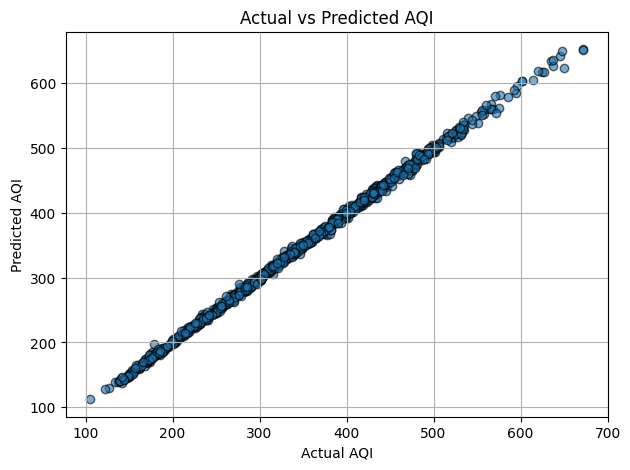

In [11]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI")
plt.grid(True)
plt.show()

In [12]:
import joblib
joblib.dump(xgb_aqi, "model/aqi.pkl")
print(" AQI Analysis Model Save")

 AQI Analysis Model Save
